In [1]:
import pandas as pd
import datetime
import numpy as np
import bcp
import ast
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
import random
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam, SGD
import math
from sklearn.svm import SVC
import pytz
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [46]:
def cleanPackets(recording_path, target_size, timezone='Asia/Jerusalem', delta=None):
    """
    Cleans and processes packet data from a CSV file, converting timestamps and filtering by packet size.

    Parameters:
    recording_path (str): Path to the CSV file containing the packet data.
    target_size (int): The packet size (Length) to filter the data on.
    timezone (str): Timezone for converting the packet's epoch times. Default is 'Asia/Jerusalem'.
    delta (timedelta, optional): A time offset to apply to the 'time' column. If provided, it shifts the times.

    Returns:
    sender_x (DataFrame): A processed DataFrame with the cleaned packet data, indexed by time and filtered by size.
    """
    
    sender_x = pd.read_csv(recording_path)
    #This code converts the 'epoch' column to a localized datetime in 'Asia/Jerusalem', sets it as the index
    sender_x['time'] = pd.to_datetime(sender_x['epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert(timezone)
    if delta is not None:
        sender_x['time'] = sender_x['time'] - sender_x['time'].min() + delta
    sender_x.set_index('time', inplace=True)
    sender_x['Time'] = sender_x['epoch'] - sender_x['epoch'].min()
    sender_x['time_diff'] = sender_x['Time'].diff().fillna(0)
    sender_x['time'] = pd.to_datetime(sender_x['epoch'], unit='s')
    sender_x['Length'] = sender_x['Length']
    sender_x = sender_x[sender_x['Length'] == target_size]
    return sender_x.copy()
    

In [45]:
def makeTimeseries(recording, col_name, chunk_size=5):
    """
    Creates a time series from a given recording, aggregating data into chunks of specified size.

    Parameters:
    recording (DataFrame): A pandas DataFrame with a datetime index, representing recorded events.
    col_name (str): The name of the column in the output time series to store the count of events per chunk.
    chunk_size (int): The size of each time chunk in seconds. Default is 5 seconds.

    Returns:
    time_series (DataFrame): A DataFrame where each row represents a time chunk (chunk_size seconds) 
                             and the corresponding count of events in that time period.
    """
    # Find the minimum and maximum times in the recording, rounded to the nearest minute
    start_time = recording.index.min().floor('min')
    end_time = recording.index.max().floor('min')
    
    # Create time series with a row every chunk_size seconds
    freque = str(chunk_size) + 'S'
    time_series = pd.DataFrame(pd.date_range(start=start_time, end=end_time, freq=freque))
    time_series = time_series[time_series[0] > recording.index.min()]
    time_series.set_index(0, inplace=True)
    
    time_series[col_name] = 0
    copy = recording.copy()
    
    # Loop through each time chunk and count the number of events within that chunk
    for index, row in time_series.iterrows():
        time = index
        e_time = time + pd.Timedelta(seconds=chunk_size)
        mask = copy.index.to_series().between(time, e_time)
        window = copy[mask]
        #print(len(window))
        # If the window has more than 2 events, record the count in the time series
        if len(window) > 2:
            time_series.at[index, col_name] = len(window)
            
    return time_series

In [44]:
def delayFilter(df, filter_depth=3):
    """
    Applies a delay-based filter to smooth the 'receiving' signal in the given DataFrame by averaging it 
    with its shifted versions.

    Parameters:
    df (DataFrame): A pandas DataFrame containing at least a 'receiving' column with time series data.
    filter_depth (int): The number of shifts (depth) to apply in the filtering process. Default is 3.

    Returns:
    df (DataFrame): The modified DataFrame where the 'receiving' column has been smoothed by averaging with 
                    its delayed/shifted versions.
    """
    for i in range(1, filter_depth):
        df['recieving'] += df['recieving'].shift(-i).fillna(0) / (i + 1)
    return df
        

In [42]:
def areTalking(sender_path, rec_path, target_size_sender, target_size_rec, chunk_size=5, timezone='Asia/Jerusalem', equalize_times=0):
    """
    Processes and compares two sets of communication data (sender and receiver) to check if they are talking 
    by analyzing the time series correlation between them.

    Parameters:
    sender_path (str): Path to the sender's packet data file.
    rec_path (str): Path to the receiver's packet data file.
    target_size_sender (int): The number of packets to process for the sender.
    target_size_rec (int): The number of packets to process for the receiver.
    chunk_size (int): The size of the chunks (in seconds) to aggregate data into time series. Default is 5 seconds.
    timezone (str): Timezone of the data for accurate time alignment. Default is 'Asia/Jerusalem'.
    equalize_times (int): 
        - If 1, the receiver's data timestamps will be shifted to align with the sender's minimum timestamp.
        - If 0, no timestamp alignment will occur. Default is 0.

    Returns:
    merged (DataFrame): A DataFrame containing the merged and aligned time series of sender and receiver data.
    """
    # Clean the sender's packet data
    sender = cleanPackets(sender_path, target_size_sender)
    
    if equalize_times == 1:
        rec =  cleanPackets(rec_path, target_size_rec, delta=sender.index.min())
    else:
        rec =  cleanPackets(rec_path, target_size_rec)
        
    # Create time series for the sender and receiver, filling missing values with zeros
    sender_ts = makeTimeseries(sender, 'sending', chunk_size=chunk_size).fillna(0)
    rec_ts = makeTimeseries(rec, 'recieving', chunk_size=chunk_size).fillna(0)
    
    merged = pd.merge(rec_ts, sender_ts, left_index=True, right_index=True, how='outer')
    merged = merged.dropna() # added to sync recordings that didnt start or end at the same time

    check(merged)
    return merged

In [43]:
def check(merged, thresh=0.1, display=0):
    """
    Analyze the correlation between 'sending' and 'receiving' signals over various time shifts 
    to determine the nature of the communication between two entities.

    Parameters:
    merged (DataFrame): A pandas DataFrame containing two columns, 'sending' and 'recieving', 
                        which represent time series data of communication.
    thresh (float): Threshold value for determining if the correlation is significant. Default is 0.1.
    display (int): If set to 1, detailed correlation and shift values are printed for debugging purposes. Default is 0.

    Returns:
    output (int): 
        - 1 if strong correlation suggests 'talking'.
        - 0.5 if moderate correlation suggests 'maybe talking but lagging'.
        - 0 if no significant correlation suggests 'not talking'.
    """
    y = 50
    corr_list = []
    # Loop through the range of shifts
    for i in range(y):
        
        if display:
            print('shift:', i- round(y/2))
            
        # Calculate the correlation with a shifted version of 'sending'
        shift_corr = merged['sending'].shift(i - round(y/2)).fillna(0).corr(merged['recieving'])
        
        if display:
            print('corr:', shift_corr)
        # Roll the 'sending' column and calculate the correlation    
        merged['sending_rolled'] = np.roll(merged['sending'], i - round(y/2))
        roll_corr = merged['sending_rolled'].corr(merged['recieving'])
        if display:
            print('corr:', roll_corr)
        corr_list.append((i- round(y/2), shift_corr, roll_corr))
        
    # Sort the correlations by the highest shift correlation (shift_corr)
    sorted_list = sorted(corr_list, key=lambda x: -x[1])
    
    grade = corr_list[round(len(corr_list)/2)][2] / sum(abs(x[2]) for x in corr_list)
    grade_shifted = sorted_list[0][2] / sum(abs(x[2]) for x in corr_list)
    output = 0
    if grade > thresh:
        print('talking')
        output = 1
    elif grade_shifted > thresh:
        print('maybe talking but lagging')
        output = 0.5
    else:
        print('not talking')
        output = 0
    print(grade)
    print(grade_shifted)
    return output

In [73]:
path_sender_x = r'C:\Users\gilad\Desktop\telegram_recordings\20240930-152500\telegram_messages20240930-152500filtered.csv'
path_rec_x = r'C:\Users\gilad\Desktop\telegram_recordings\20240910-162337\telegram_messages20240910-162337_filtered_Chen.csv'

In [74]:
cleaned = cleanPackets(path_sender_x, 1514)
sender_x = pd.read_csv(path_sender_x)
#This code converts the 'epoch' column to a localized datetime in 'Asia/Jerusalem', sets it as the index
sender_x['time'] = pd.to_datetime(sender_x['epoch'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Jerusalem')
sender_x.set_index('time', inplace=True)
sender_x['Time'] = sender_x['epoch'] - sender_x['epoch'].min()
sender_x['time_diff'] = sender_x['Time'].diff().fillna(0)
sender_x['time'] = pd.to_datetime(sender_x['epoch'], unit='s')
cleaned = sender_x

C:\Users\gilad\AppData\Local\Temp\ipykernel_107308\2481743083.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  cleaned_sec = cleaned['2024-09-30 17:47:45+03:00':'2024-09-30 17:48:15+03:00']


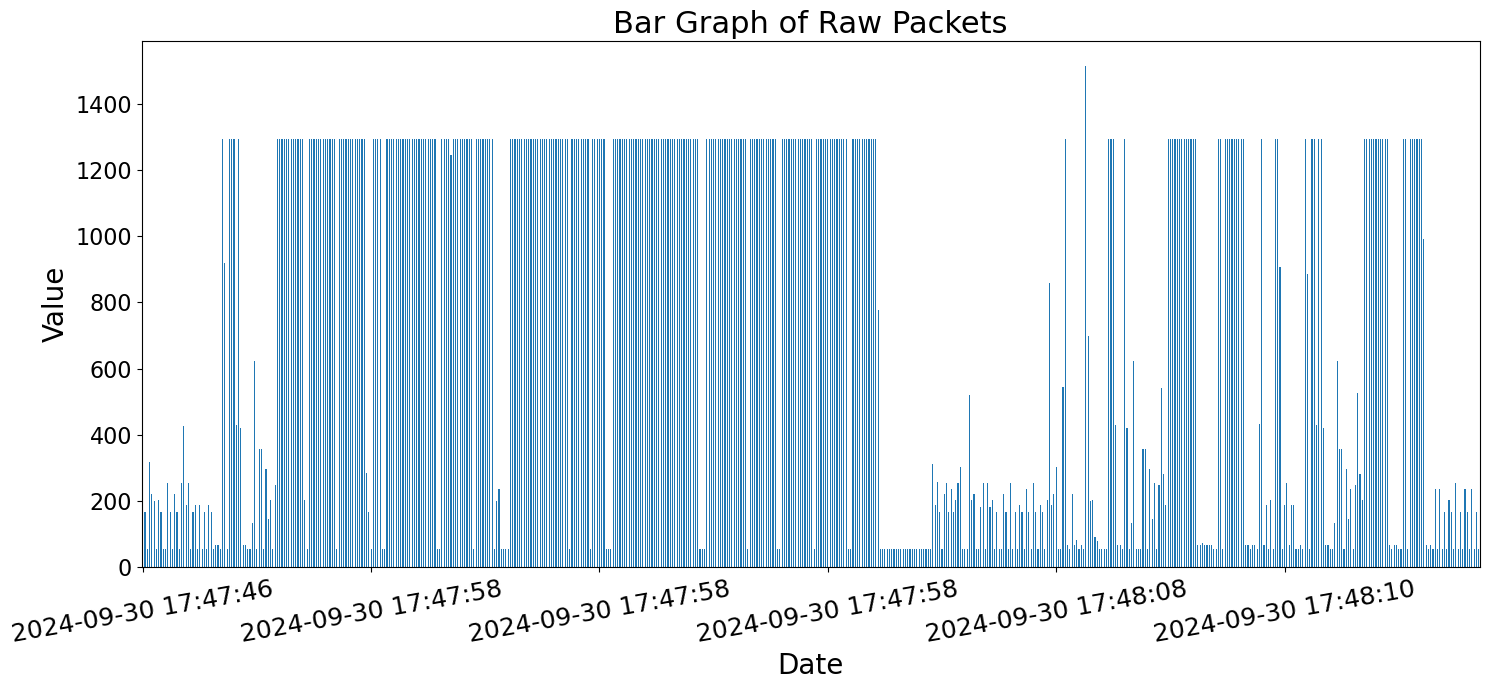

In [101]:
cleaned_sec = cleaned['2024-09-30 17:47:45+03:00':'2024-09-30 17:48:15+03:00']
ax = cleaned_sec['Length'].plot(kind='bar', figsize=(15, 7))
tick_positions = range(0, len(cleaned_sec), 100)  # Show every 5th tick, for example
ax.set_xticks(tick_positions)
ax.set_xticklabels(cleaned_sec.index[tick_positions].strftime('%Y-%m-%d %H:%M:%S'), rotation=45, fontsize=18)  # Rotate x-axis labels if necessary
ax.tick_params(axis='y', labelsize=16)

plt.xlabel('Date', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Bar Graph of Raw Packets', fontsize=22)
plt.xticks(rotation=10)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('raw_packets_section.png', dpi=300)
plt.show()

In [76]:
timeseries = makeTimeseries(cleaned, 'sending', chunk_size=5)

In [70]:
timeseries_rec = makeTimeseries( cleanPackets(path_sender_x, 1294), 'receiving', chunk_size=5)

In [12]:
pd.set_option('display.max_rows', None)

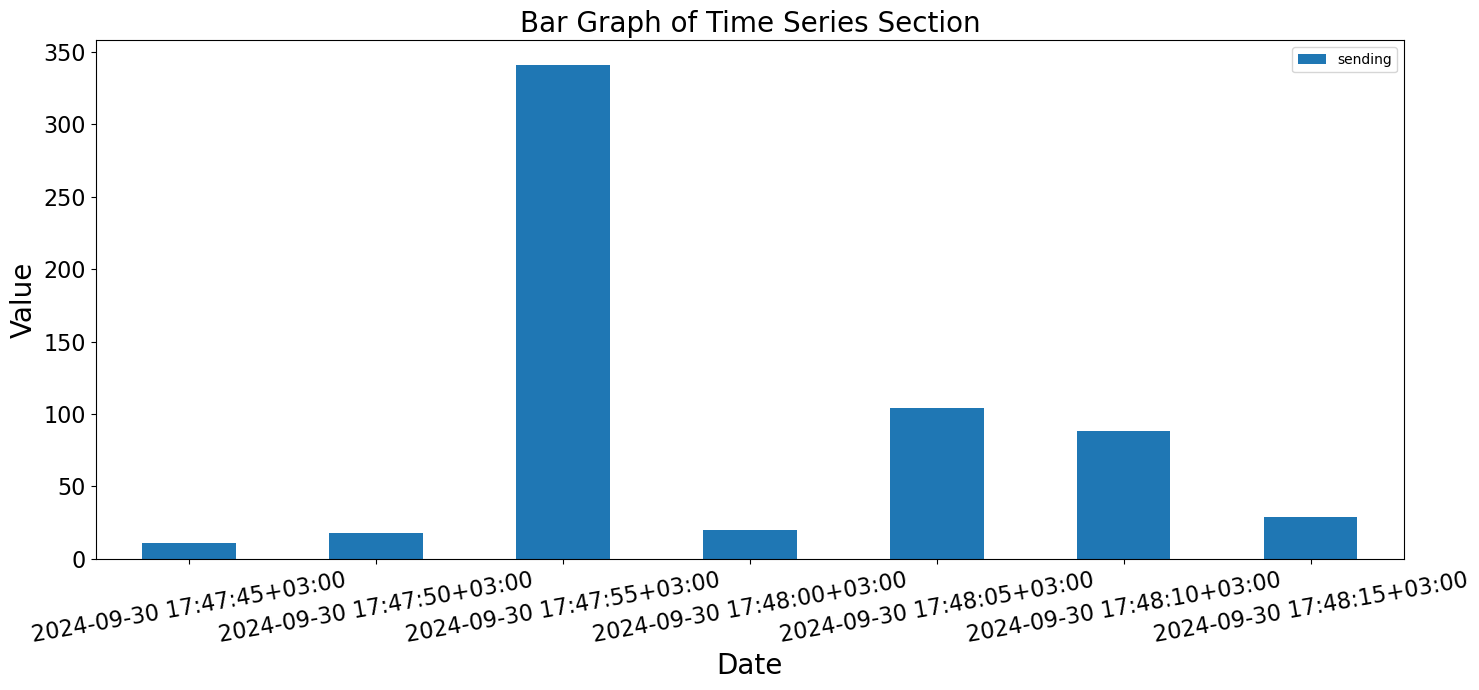

In [100]:
timeseries_sec = timeseries['2024-09-30 17:47:45+03:00':'2024-09-30 17:48:15+03:00']
time_indices = timeseries_sec.index
timeseries_rec_sec = timeseries_rec['2024-09-10 18:39:35+03:00':'2024-09-10 18:40:45+03:00']
ax = timeseries_sec.plot(kind='bar', figsize=(15, 7))
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
#timeseries_rec_sec.plot(kind='bar', color='red', figsize=(10, 6), ax=ax)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.title('Bar Graph of Time Series Section', fontsize=20)
plt.xticks(rotation=10)  # Rotate x-axis labels if necessary
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.savefig('timeseries_section.png', dpi=300)
plt.show()

In [13]:
sender_paths = [r'C:\Users\gilad\Desktop\telegram_recordings\20240910-162337\telegram_messages20240910-162337filtered.csv',
               r'C:\Users\gilad\Desktop\telegram_recordings\20240906-153615\telegram_messages20240906-153615filtered.csv',
               r'C:\Users\gilad\Desktop\telegram_recordings\20240811-111116\telegram_messages20240811-111116filtered.csv',
               r'C:\Users\gilad\Desktop\telegram_recordings\20240930-152500\telegram_messages20240930-152500filtered.csv',
               r'C:\Users\gilad\Desktop\telegram_recordings\20241001-125716\telegram_messages20241001-125716filtered.csv']
rec_paths = [r'C:\Users\gilad\Desktop\telegram_recordings\20240910-162337\telegram_messages20240910-162337_filtered_Chen.csv',
            r'C:\Users\gilad\Desktop\telegram_recordings\20240906-153615\telegram_messages20240906-153615_filtered_Chen (2).csv',
            r'C:\Users\gilad\Desktop\telegram_recordings\20240811-111116\telegram_messages20240811-111116_filtered_Chen.csv',
            r'C:\Users\gilad\Desktop\telegram_recordings\20240930-152500\telegram_messages20240930-152500_filtered_Chen.csv',
            r'C:\Users\gilad\Desktop\telegram_recordings\20241001-125716\telegram_messages20241001-125716_filtered_Chen.csv']

In [47]:
def makeDataset(df, label, resample='1H'):
    """
    Creates a dataset by resampling the given DataFrame into specified time intervals and calculating 
    statistical features between 'sending' and 'receiving' columns.

    Parameters:
    df (DataFrame): A pandas DataFrame containing at least 'sending' and 'receiving' columns.
    label (str/int): The label to be assigned to each entry in the dataset (e.g., class label for supervised learning).
    resample (str): Time interval to resample the data. Default is '1H' (1 hour).

    Returns:
    nfd (DataFrame): A new DataFrame containing the calculated features for each resampled chunk. 
                     The columns are:
                     - 'label': The provided label for the dataset entries.
                     - 'sending': The sum of 'sending' values in the chunk.
                     - 'recieving': The sum of 'receiving' values in the chunk.
                     - 'dot': The dot product between 'sending' and 'receiving' vectors.
                     - 'distance': The Euclidean distance between 'sending' and 'receiving' vectors.
                     - 'cosine_similarity': The cosine similarity between 'sending' and 'receiving' vectors.
                     - 'corr': The Pearson correlation coefficient between 'sending' and 'receiving' values.
                     - 'cross': The cross-correlation between 'sending' and 'receiving' values.
    """
    # Resample the data into chunks based on the given time interval
    chunks = df.copy().resample(resample)
    
    # Store each chunk in a list of DataFrames
    chunked_dfs = [group for _, group in chunks]
    entry_list = []
    for i, chunk_df in enumerate(chunked_dfs):
        
        chunk_df = chunk_df.fillna(0)
        
        # Convert the 'sending' and 'receiving' columns to numpy arrays
        vec1 = np.array(chunk_df['sending'].values)
        vec2 = np.array(chunk_df['recieving'].values)

        # Calculate various statistics and features
        corr = chunk_df['sending'].corr(chunk_df['recieving'])
        dot_product = np.dot(vec1, vec2)
        cross = np.correlate(vec1, vec2, mode='valid')
        distance = np.linalg.norm(vec1 - vec2)
        cosine_similarity = np.sum(vec1 * vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        
        entry_list.append((label, vec1.sum(), vec2.sum(), dot_product, distance, cosine_similarity, corr, cross))

    # Create a DataFrame from the entry list
    nfd = pd.DataFrame(entry_list, columns=['label', 'sending', 'recieving', 'dot', 'distance', 'cosine_similarity', 'corr', 'cross'])
    
    return nfd

In [48]:
def pathToDataset(sender_paths, rec_paths):
    """
    Processes multiple sender and receiver paths, calculates features, and creates a labeled dataset.

    Parameters:
    sender_paths (list): List of file paths for the sender packet data CSVs.
    rec_paths (list): List of file paths for the receiver packet data CSVs.

    Returns:
    result (DataFrame): A pandas DataFrame containing labeled features for each sender-receiver pair.
                        The columns include:
                        - 'label': 1 if sender and receiver correspond (same index), 0 otherwise.
                        - 'sending': The sum of 'sending' values.
                        - 'recieving': The sum of 'receiving' values.
                        - 'dot': The dot product between 'sending' and 'receiving' vectors.
                        - 'distance': The Euclidean distance between 'sending' and 'receiving' vectors.
                        - 'cosine_similarity': The cosine similarity between 'sending' and 'receiving' vectors.
                        - 'corr': The Pearson correlation coefficient between 'sending' and 'receiving' values.
    """
    
    # Initialize an empty DataFrame with the specified columns
    result = pd.DataFrame(None, columns=['label', 'sending', 'recieving', 'dot', 'distance', 'cosine_similarity', 'corr'])

    # Loop through each sender path
    for i, path in enumerate(sender_paths):
        # Loop through each receiver path
        for j, recpath in enumerate(rec_paths):
            
            if i == j:
                # If sender and receiver correspond (same index), set label to 1
                label = 1
                temp = areTalking(sender_paths[i], rec_paths[j], 1514, 1294, equalize_times=0)
            else:
                # If sender and receiver do not correspond (different index), set label to 0
                label = 0
                temp = areTalking(sender_paths[i], rec_paths[j], 1514, 1294, equalize_times=1)
                
            # Generate the dataset for this sender-receiver pair and concatenate with the result DataFrame    
            result = pd.concat([result, makeDataset(temp, label)])
    return result

In [ ]:
dataset = pathToDataset(sender_paths, rec_paths)

In [27]:
dataset.dropna(inplace=True)

In [28]:
dataset['label'] = pd.to_numeric(dataset['label'], errors='raise')
dataset['sending'] = pd.to_numeric(dataset['sending'], errors='raise')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 4
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   label              151 non-null    int64  
 1   sending            151 non-null    int64  
 2   recieving          151 non-null    float64
 3   dot                151 non-null    float64
 4   distance           151 non-null    float64
 5   cosine_similarity  151 non-null    float64
 6   corr               151 non-null    float64
 7   cross              151 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 10.6+ KB


In [29]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('label', axis=1).dropna(), dataset['label'], test_size=0.2, random_state=43)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)



# Train a model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


model2 = DecisionTreeClassifier(max_depth=3)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)
print("\nDecision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Precision:", precision_score(y_test, y_pred2, average='weighted'))
print("Recall:", recall_score(y_test, y_pred2, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred2, average='weighted'))

model3 = SVC(kernel='poly', degree=3)  # Default is a linear kernel, can be changed by specifying the kernel parameter
model3.fit(X_train, y_train)

# Evaluate SVM
y_pred3 = model3.predict(X_test)
print("\nSupport Vector Machine Results:")
print("Accuracy:", accuracy_score(y_test, y_pred3))
print("Precision:", precision_score(y_test, y_pred3, average='weighted'))
print("Recall:", recall_score(y_test, y_pred3, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred3, average='weighted'))

model4 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)  # Random Forest with 100 trees
model4.fit(X_train, y_train)

# Evaluate Random Forest
y_pred4 = model4.predict(X_test)
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred4))
print("Precision:", precision_score(y_test, y_pred4, average='weighted'))
print("Recall:", recall_score(y_test, y_pred4, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred4, average='weighted'))

Logistic Regression Results:
Accuracy: 0.967741935483871
Precision: 0.9691444600280505
Recall: 0.967741935483871
F1 Score: 0.9671515918195235

Decision Tree Results:
Accuracy: 0.967741935483871
Precision: 0.9691444600280505
Recall: 0.967741935483871
F1 Score: 0.9671515918195235

Support Vector Machine Results:
Accuracy: 0.967741935483871
Precision: 0.9691444600280505
Recall: 0.967741935483871
F1 Score: 0.9671515918195235

Random Forest Results:
Accuracy: 0.967741935483871
Precision: 0.9691444600280505
Recall: 0.967741935483871
F1 Score: 0.9671515918195235


In [49]:
def testData(dataset, random_state=43):
    """
    Splits the dataset into training and testing sets, applies SMOTE for class balancing, trains multiple models,
    and evaluates their performance using various metrics.

    Parameters:
    dataset (DataFrame): The dataset to be split and used for training/testing. It must contain a 'label' column 
                         and other feature columns.
    random_state (int): Random state for reproducibility of train-test split and SMOTE. Default is 43.

    Returns:
    avg_metrics (dict): A dictionary containing the average values of Accuracy, Precision, Recall, and F1 Score
                        across all tested models.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.drop('label', axis=1).dropna(),
        dataset['label'],
        test_size=0.2,
        random_state=random_state
    )

    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(max_depth=3),
        'Support Vector Machine': SVC(kernel='poly', degree=3),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=3)
    }

    metrics = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
        metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
        metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))

    # Calculate average metrics
    avg_metrics = {metric: sum(scores) / len(scores) for metric, scores in metrics.items()}

    return avg_metrics


In [31]:
# Example list of random states to test
all_avg_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Assuming you have a dataset called `dataset`
for state in range(40, 81):
    avg_metrics = testData(dataset, random_state=state)
    
    for metric, value in avg_metrics.items():
        all_avg_metrics[metric].append(value)

# Calculate overall averages across all random states
overall_avg_metrics = {metric: sum(scores) / len(scores) for metric, scores in all_avg_metrics.items()}

# Print the overall average metrics
print("Overall Average Metrics across all random states:")
for metric, value in overall_avg_metrics.items():
    print(f"{metric}: {value:.4f}")


Overall Average Metrics across all random states:
Accuracy: 0.9599
Precision: 0.9632
Recall: 0.9599
F1 Score: 0.9589
